# Part 3 - Predictive modeling

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pycaret.classification import *
import seaborn as sns
%matplotlib inline

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

#### Reading Json data into panda dataframe

In [3]:
f = open('ultimate_data_challenge.json',)
data = json.load(f)
df = pd.json_normalize(data)

In [4]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Data Wrangling

Notice phone attributes have missing values. It could because user using operating system beyond android and iphone (e.g. Window phone, or login using desktop). Fill missing values with "other" for now.

In [6]:
df['phone'] = df['phone'].fillna('other')

Signup_date and last_trip_date should be in datatime format

In [7]:
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')

Question did not specify what is the starting point for preceding 30 days. We pick the maximum values under last_trip_date column as the start date, and that is 2014-07-01

In [8]:
today = df['last_trip_date'].max()
today

Timestamp('2014-07-01 00:00:00')

**Target creation**
- subtract all values under last_trip_date by 2014-07-01, convert that into integer
- if integer values are less than 30, we treat them as 'retained' customers, assign 1 under variable 'active', eles 0

In [9]:
df['day_since_last'] = (today - df['last_trip_date'])/np.timedelta64(1, 'D')

In [10]:
df['active'] = (df['day_since_last'] < 30).astype(int)

In [11]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,day_since_last,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2.0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108.0,0


Remove signup_date, last_trip_date, and day_since_last features as they won't be used as features.

In [12]:
df_1 = df.drop(['signup_date', 'last_trip_date', 'day_since_last'], axis=1)

In [13]:
ave_retain_rate = 1 - df_1['active'].sum()/len(df_1)
print('Overall attrition rate is {:.2%}'.format(ave_retain_rate))

Overall attrition rate is 63.38%


Baseline model would be to assume all clients are attrited, and the accuracy will be **63.38%**

#### Exploratory Analysis

Using 63.38% as benchmark, we want to see which attributes in the dataset will show significant differentiation from the benchmark.

In [14]:

def form_crosstab(attr):
    """create crosstab dataframe among attribute across active users

    Args:
    attr: attributes in the dataframe

    Returns:
    crosstab table
    """
    table = pd.crosstab(df[attr], df['active'], values=df['active'],
                        aggfunc='count', normalize='index')
    return table

In [15]:

def bar_plot(data, var):
    """Stack bar group to show the result of % of active by attribute

    Args:
    data: crosstab table object
    var: attritbute in the dataframe

    Returns:
    stacked bar graph
    """
    data.plot.bar(stacked=True, figsize=(15, 5))
    plt.title('attrition rate by '+var, fontsize=20)
    plt.xlabel(var, fontsize=15)
    plt.ylabel('%', fontsize=15)
    plt.axhline(y=ave_retain_rate, color='red', label='benchmark')
    plt.legend(('benchmark', 'attrited', 'retained'))
    plt.autoscale(enable=True)
    plt.show()

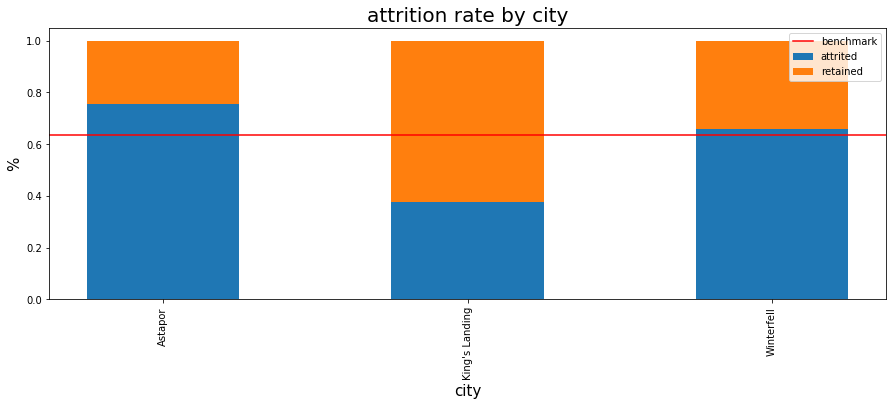

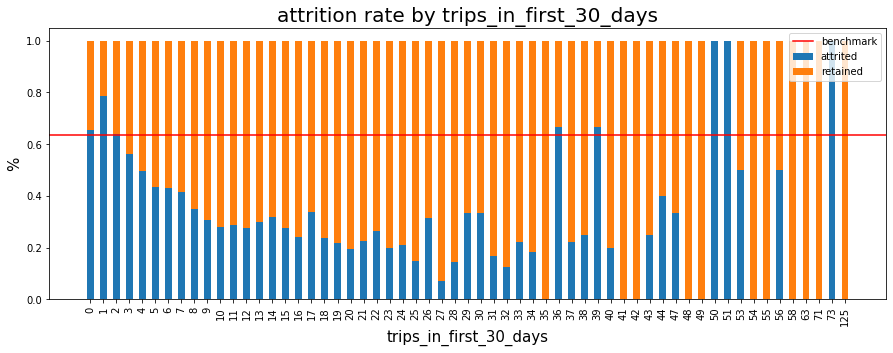

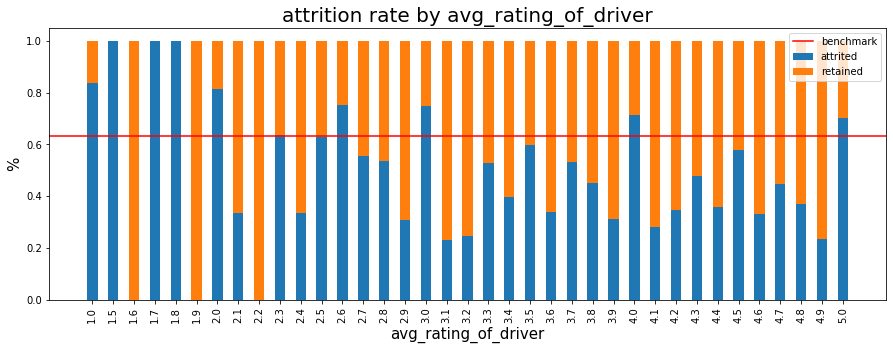

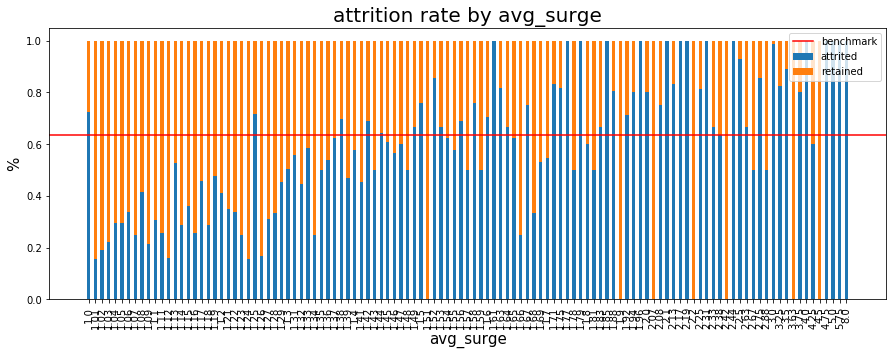

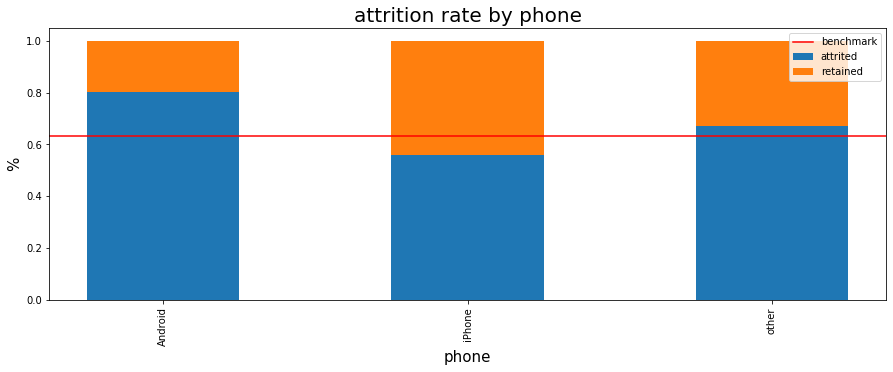

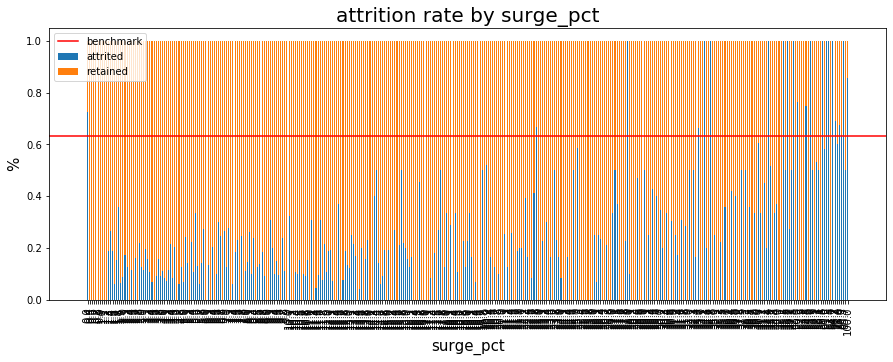

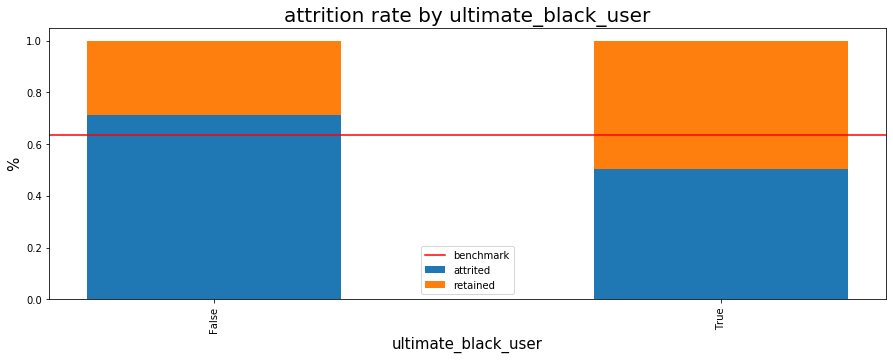

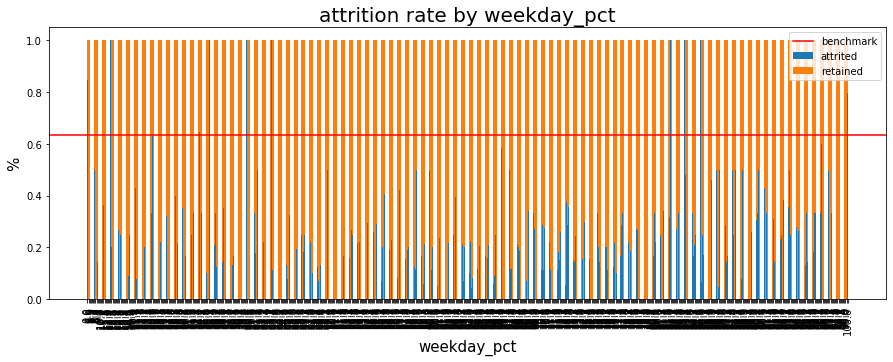

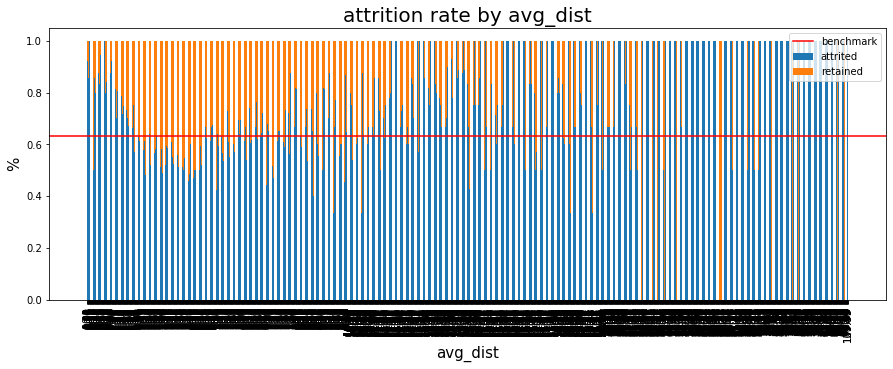

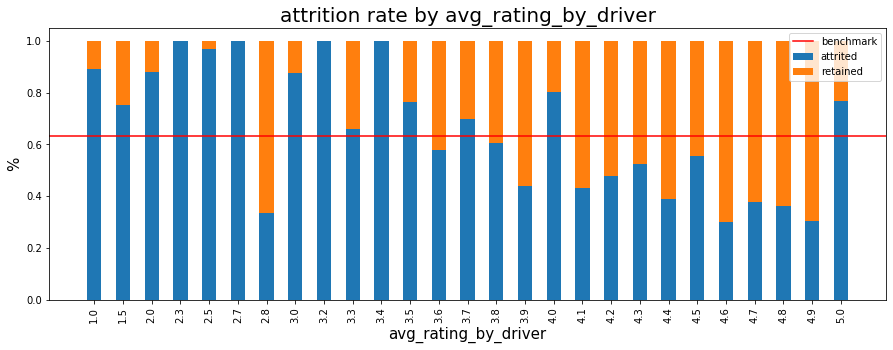

In [16]:

for col in df_1.columns[:-1]:
    bar_plot(form_crosstab(col), col)

From the above visualization, the follow attributes appear to be have influence on user attritions
- city, phone, avg_surge, surge_pct, ultimate_black_user
- trips_in_first_30_days appear to have inverse linear relationship with attrition from 0-30 trips, but beyond that relationship is unclear. We will keep this attribute for to see if that will help improve the model

### Chi Square Test

Testing the significance on the category variable influence to attritions.

In [17]:

def chi_sq_test(attr):
    """measure p-value of chi_sq test for attributes

    Args:
    attr: attribute that is being test

    Returns:
    p-values, degree of freedom
    """
    table = pd.crosstab(df[attr], df['active'],
                        values=df['active'], aggfunc='count')
    stat, p, dof, expected = stats.chi2_contingency(table[[0,1]])
    print('attribute tested: {}'.format(attr))
    print('p-value: {:.2f}'.format(p))
    print('degree of freedom: {:.0f}'.format(dof))

In [18]:
chi_sq_test('city')

attribute tested: city
p-value: 0.00
degree of freedom: 2


In [19]:
chi_sq_test('ultimate_black_user')

attribute tested: ultimate_black_user
p-value: 0.00
degree of freedom: 1


Both city and ultimate_black_user show dependence to attrition rates.

In [20]:
chi_sq_test('phone')

attribute tested: phone
p-value: 0.00
degree of freedom: 2


### Setting final dataframe

Per analysis above, the features to be used for machine learning analysis are 
- **city**: city this user signed up in
- **phone**: primary device for this user
- **avg_surge**: The average surge multiplier over all of this user’s trips
- **surge_pct**: the percent of trips taken with surge multiplier > 1
- **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up

In [21]:
final_df = df_1[['city', 'phone', 'avg_surge', 'surge_pct',
                 'ultimate_black_user', 'trips_in_first_30_days', 'active']]

In [22]:
final_df.head()

,city,phone,avg_surge,surge_pct,ultimate_black_user,trips_in_first_30_days,active
0,King's Landing,iPhone,1.10,15.4,True,4,1
1,Astapor,Android,1.00,0.0,False,0,0
2,Astapor,iPhone,1.00,0.0,False,3,0
3,King's Landing,iPhone,1.14,20.0,True,9,1
4,Winterfell,Android,1.19,11.8,False,14,0


### Model Training

In [23]:
exp = setup(final_df, target='active', train_size=0.8)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,4374
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(50000, 7)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [24]:
compare_models(fold=6)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.770500,0.822300,0.579900,0.737300,0.649200,0.482200
1,CatBoost Classifier,0.770100,0.822400,0.574400,0.739700,0.646600,0.480200
2,Gradient Boosting Classifier,0.767200,0.819200,0.570800,0.734200,0.642300,0.473700
3,Extreme Gradient Boosting,0.767100,0.819300,0.569400,0.735000,0.641600,0.473200
4,Ada Boost Classifier,0.760800,0.811300,0.565100,0.721400,0.633700,0.460000
5,Extra Trees Classifier,0.756300,0.795300,0.542200,0.723100,0.619700,0.445700
6,Random Forest Classifier,0.755400,0.799900,0.543300,0.720100,0.619300,0.444200
7,Decision Tree Classifier,0.745900,0.740400,0.510400,0.714100,0.595200,0.417400
8,K Neighbors Classifier,0.743000,0.761000,0.539100,0.691800,0.605800,0.419500
9,Logistic Regression,0.726900,0.765400,0.486000,0.677500,0.565800,0.374500


Based on initial model performance, we choose the top models that have the highest accuracy (Catboost and Light Gradient Boosting Machine), then we will choose one tree base model Random Forecast for further analysis.

In [25]:
cat = create_model('catboost', fold=4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7710,0.8229,0.5822,0.7372,0.6506,0.4838
1,0.7665,0.8211,0.5822,0.7259,0.6462,0.4750
2,0.7700,0.8199,0.5655,0.7450,0.6430,0.4780
3,0.7746,0.8260,0.5751,0.7511,0.6514,0.4892
Mean,0.7705,0.8225,0.5763,0.7398,0.6478,0.4815
SD,0.0029,0.0023,0.0068,0.0094,0.0034,0.0054


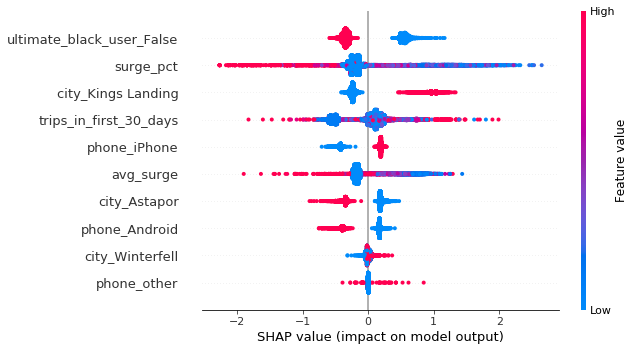

In [26]:
interpret_model(cat)

In [27]:
lightgbm = create_model('lightgbm', fold=4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7725,0.8220,0.5844,0.7397,0.6529,0.4872
1,0.7651,0.8203,0.5806,0.7234,0.6441,0.4720
2,0.7698,0.8200,0.5710,0.7410,0.6450,0.4789
3,0.7725,0.8246,0.5751,0.7455,0.6493,0.4851
Mean,0.7700,0.8217,0.5778,0.7374,0.6478,0.4808
SD,0.0030,0.0018,0.0051,0.0084,0.0035,0.0059


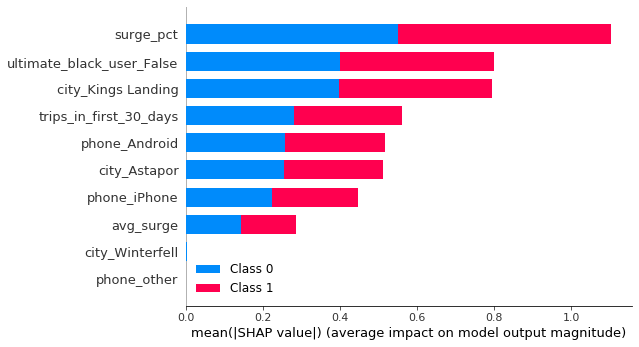

In [28]:
interpret_model(lightgbm)

In [29]:
rfc = create_model('rf', fold=4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7559,0.7997,0.5382,0.7244,0.6176,0.4440
1,0.7536,0.7996,0.5467,0.7135,0.6190,0.4416
2,0.7540,0.8004,0.5437,0.7162,0.6181,0.4417
3,0.7562,0.8016,0.5355,0.7268,0.6167,0.4439
Mean,0.7549,0.8003,0.5410,0.7202,0.6179,0.4428
SD,0.0011,0.0008,0.0044,0.0055,0.0009,0.0011


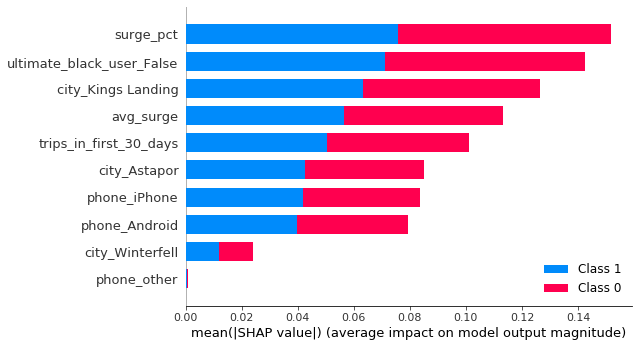

In [30]:
interpret_model(rfc)

#### Performance Summary

|Model | Accuracy |
| --- | --- |
| Baseline | 63.38% |
| Random Forest | 75.23% |
| Catboost | 76.78% |
| Lightgbm | 76.75%|

Model performance is at the 75%-77% range, which is ~12-13% better than baseline model.

### Insights:

- All models suggested that users who took more trips with multiplier > 1 are likely to use the services long term. Perhaps they view the service as expensive as they don't get to enjoy the base rate of the service often. Ultimate may consider providing some promotion to that users segment. Promotion examples could be bundle trips purchases, or award them points which they can use in other purchases. After all, those are the users who pay higher price/trip, and they have long term client value if we can retain them.
- King's landing city client tend to be more loyal than the other two cities. Good to understand if it is demand or supply driven. If it is demand driven, Ultimate could consider adjusting the rate in the other cities to boost loyalty. If it is supply related, Ultimate can extend the recruiting efforts in the other two cities
- It is surprising to see that phone pay a role in loyalty. Recommend Ulitmate software engineer team to revisit Android app user experience.